In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import eli5
import numpy as np
shap.initjs()

In [3]:
# Read in data and filter to time frame
file_name = ""
df_load = dataiku.Dataset(file_name).get_dataframe()

In [4]:
def prediction_scope(df_in, start_i, end_i):
    start_date = pd.Timestamp(start_i)
    end_date = pd.Timestamp(end_i)

    df = df_in.loc[lambda x: x.event_date.between(start_date, end_date)]
    
    return df

In [5]:
# LIGHTGBM PREDICTION CLASS FOR TIMESERIES DATA
class timeseries_lgb():

    
    def __init__(self, df_in, target, date_field, num_periods, lgbm_kwargs, verbose, freq):
        self.df_in = df_in
        self.date = date_field
        assert date_field in df_in.columns, "Input data does not contain the date field"
        # Sort values by date
        self.df_in = self.df_in.set_index(self.date).sort_index()
        
        self.target = target
        assert target in df_in.columns, "Input data does not contain the target" 
        
        
        self.freq = freq
        self.num_periods = num_periods
        self.lgbm_kwargs = lgbm_kwargs
        self.model = lgb.LGBMRegressor(**lgbm_kwargs)
        self.score = None
        self.train_preds = None
        self.sc = None
        self.verbose = verbose
        
        
    def shift_target(self):
        # Add target (i.e predict sales in n periods)
        target_name = f"{self.target}_plus_{self.num_periods}{self.freq}"
        target_o = self.df_in[self.target].shift(-self.num_periods).rename(target_name).dropna()
        return target_o
        
        
    def prepare_data(self, data, fit=False):
        # Standard scale features
        if fit:
            self.sc = StandardScaler()
            output_array = self.sc.fit_transform(data)
        else:
            assert self.sc is not None, "Please fit the scaler first"
            output_array = self.sc.transform(data)
        output = pd.DataFrame(output_array, index = data.index, columns = data.columns)
        return output
        

    def train_test(self, train_size):
        y = self.shift_target()
        X = self.df_in.reindex(y.index, axis=0).drop([self.target], axis=1)

        # Training sample - train_size% of historical chronoligical data
        split_date = X.head(int(len(self.df_in)*train_size)).index[-1]
        if self.verbose:
            print(f"train/test split at {split_date}")
                      
        self.X_train = X.loc[:split_date, :].sample(frac=1, random_state=42)
        self.y_train = y.loc[:split_date]
        
        # Test data - most recent 1 - train_size% data - chronological order preserved
        self.X_test = X.loc[lambda x: x.index > split_date, :]
        self.y_test = y.loc[lambda x: x.index > split_date]

        if self.verbose:
            print("X train / test size", len(self.X_train), len(self.X_test))
            print("y train / test size", len(self.y_train), len(self.y_test))

        # Fit LGBMRegressor
        X_train_transformed = self.prepare_data(self.X_train, fit=True)
        self.model.fit(X_train_transformed, self.y_train)
        self.dumb = lambda x: [self.y_train.mean()]*len(x)
        
        # Make prediction for test data
        self.results = self.predict(self.X_test)[['y_pred']].assign(y_mean= lambda x: self.dumb(x))
        y_pred = self.results['y_pred'].shift(-self.num_periods, freq=self.freq).dropna()
        
        # Call score model function
        self.score_model(y_pred, self.y_test)

        return self
    
    
    # Predict y from input dataframe - calling prepare data in process
    def predict(self, df_in):
        if self.date in df_in.columns:
            df_in = df_in.set_index(self.date)
        y_pred = pd.Series(df_in.pipe(self.prepare_data).pipe(self.model.predict),
                           index = df_in.index.shift(self.num_periods, freq=self.freq),
                           name='y_pred'
                 )
        output = df_in.join(y_pred, how='outer')
        return output
     
    
    # Score predictions against test and baseline dumb_model
    def score_model(self, y_pred, y_test):
        # Get scores of model
        dumb_score = np.sqrt(metrics.mean_squared_error(y_test, self.dumb(y_test)))
        self.score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        if self.verbose:
            print('RMSE: (dumb model):', dumb_score)
            print('RMSE:', self.score, '\n')

    
    # Plot the prediction against the actual and dumb mean model
    def plot(self, title=''):
        #plot_data = pd.concat([self.y_train.sort_index(), self.y_test], axis=0).to_frame().join(self.results)
        ys =[self.target, "y_pred", "y_mean"]
        plot_data = self.df_in.join(self.results)[ys]
        line_style = ['g-+', 'r-o', 'k-']
        plt.figure(figsize=(15,10))
        for i,col in enumerate(plot_data.columns):
            plt.plot(plot_data[col], line_style[i])
        plt.title(title)
        plt.grid(True)
        plt.legend(ys)

In [6]:
# CREATE GRIDSEARCH FUNCTION
from itertools import product

def define_grid(grid_dictionary):
    return iter({a:b for a,b in zip(grid_dictionary.keys(),params)} for params in product(*grid_dictionary.values()))



def lgbm_gridsearch(df_in, lgbm_params_dict_i, target_i, num_periods, freq, event_i, select_cols_i, train_i, verbose=True):
    results = []
    for lgbm_params in define_grid(lgbm_params_dict_i):
        m = timeseries_lgb(df_in, target = target_i, date_field = event_i, num_periods=num_periods,
                           lgbm_kwargs = lgbm_params, verbose = verbose, freq=freq)
        m.train_test(train_size=train_i)
        results.append(m)
    return results


# GET BEST MODEL AND SCORE
def grid_best_model(results_list):
    best_score = min([model.score for model in results_list])
    best_models = [model for model in results_list if model.score == best_score]
    print("best_score: ", best_score)

    for model in best_models:
        print(model.lgbm_kwargs)
        
    return best_score, best_models


# Now for the best parameters, iterate over the train/test split difference
def iterate_split_ratio(df_test, target_i, date_field, num_periods, freq, params_i, 
                        x0=0.65, x1=0.85, n=10, verbose=True):
    for split_ratio in linspace(x0, x1, n):
        m = timeseries_lgb(df_test, target = target_i, date_field = event_i, num_periods=num_periods,
                           lgbm_kwargs = params_i, verbose = verbose, freq=freq)
        m.train_test(train_size=split_ratio)
        m.plot(title = f"Score :{m.score}, ratio: {split_ratio}")

### 1. MODEL 1 - ALL FEATURES, ALL TIME

In [8]:
# Call data scope function
df = prediction_scope(df_load, '1995-03-31', '2019-06-30')

# GRIDSEARCH INPUTS
target_i = "sales"
event_i = 'event_date'
select_cols = [c for c in df.columns]
lgbm_params_dict = {
    'num_leaves': [31],
    'max_depth' : [-1],
    'learning_rate': [0.06, 0.1],
    'min_child_samples': [5, 10, 22,23]}
train_i = 0.7

results = lgbm_gridsearch(df, lgbm_params_dict, target_i, 4, 'Q', event_i, select_cols, train_i, verbose=False)

# Call grid_best_model function
best_score, best_models = grid_best_model(results)

best_score:  46443.687376156835
{'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.06, 'min_child_samples': 23}


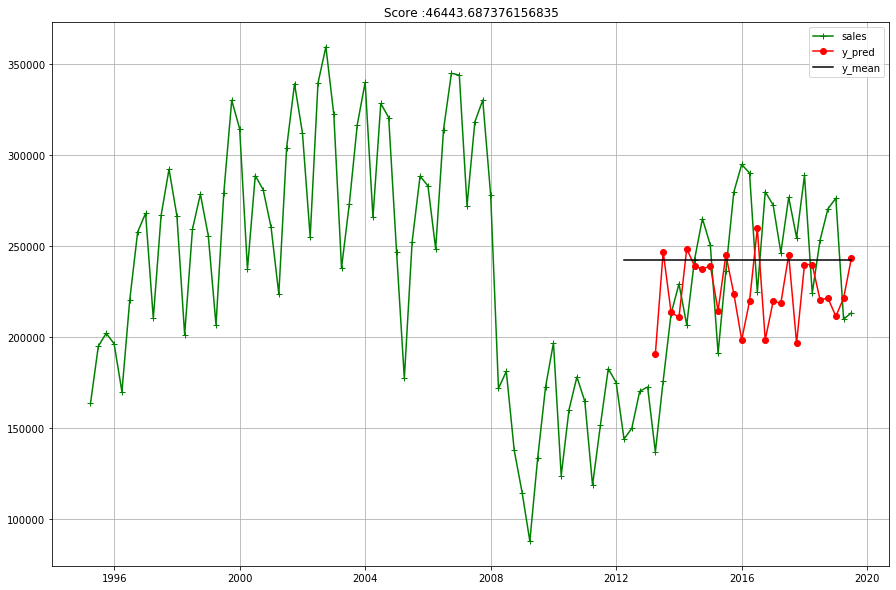

In [10]:
# Plot results of best model for past and future
best_models[0].plot(title = f"Score :{best_models[0].score}")

train/test split at 2010-09-30 00:00:00
X train / test size 63 31
y train / test size 63 31
RMSE: (dumb model): 49814.47139969939
RMSE: 57110.69050462964 

train/test split at 2011-03-31 00:00:00
X train / test size 65 29
y train / test size 65 29
RMSE: (dumb model): 44926.862934528726
RMSE: 57724.7012209812 

train/test split at 2011-12-31 00:00:00
X train / test size 68 26
y train / test size 68 26
RMSE: (dumb model): 38226.90256339153
RMSE: 46443.687376156835 

train/test split at 2012-06-30 00:00:00
X train / test size 70 24
y train / test size 70 24
RMSE: (dumb model): 31309.624981845045
RMSE: 37886.29233116467 

train/test split at 2012-12-31 00:00:00
X train / test size 72 22
y train / test size 72 22
RMSE: (dumb model): 32321.83108798949
RMSE: 32017.964266119183 

train/test split at 2013-06-30 00:00:00
X train / test size 74 20
y train / test size 74 20
RMSE: (dumb model): 33292.290654379256
RMSE: 42628.387285918914 

train/test split at 2013-12-31 00:00:00
X train / test size

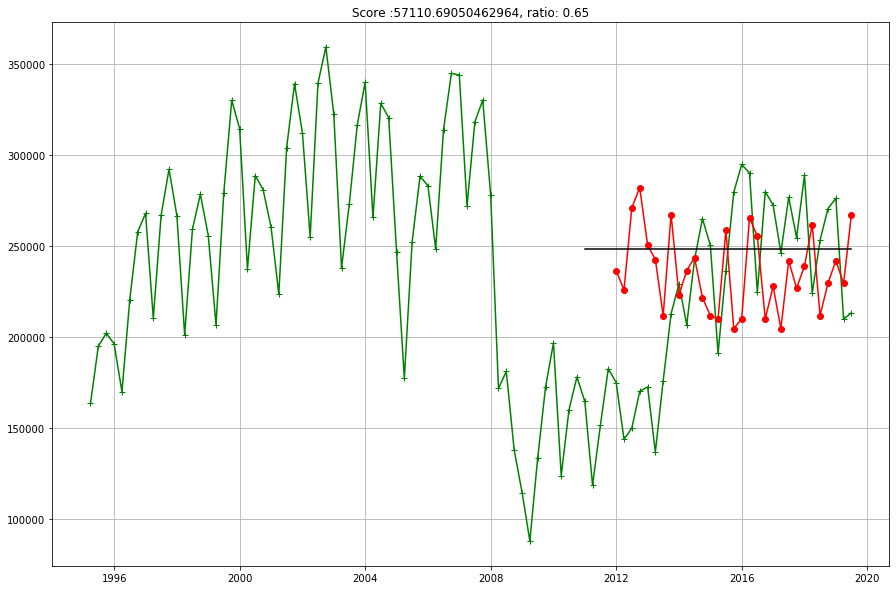

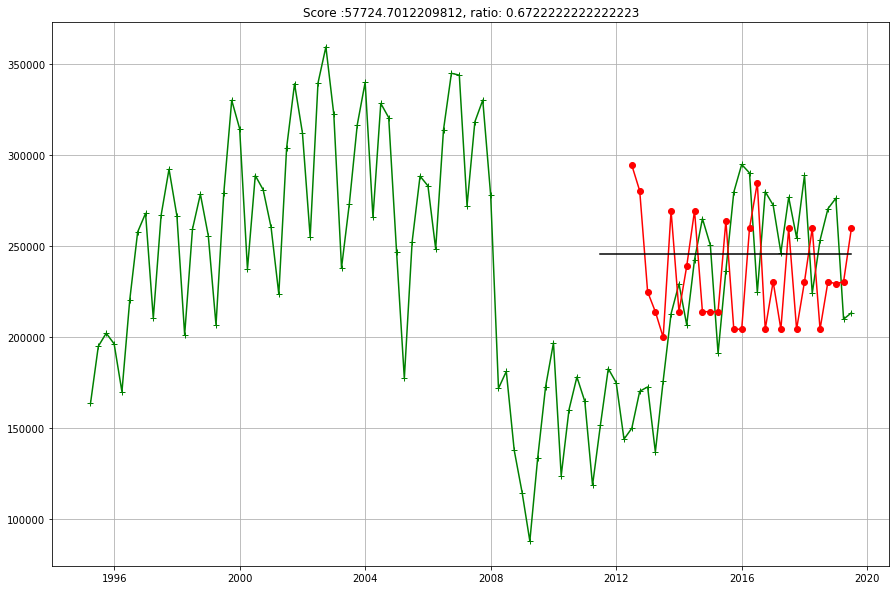

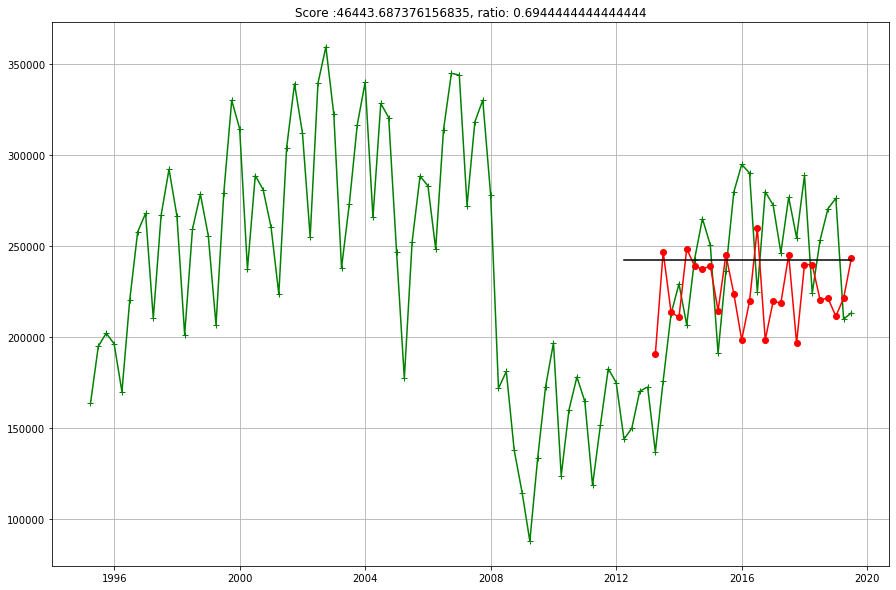

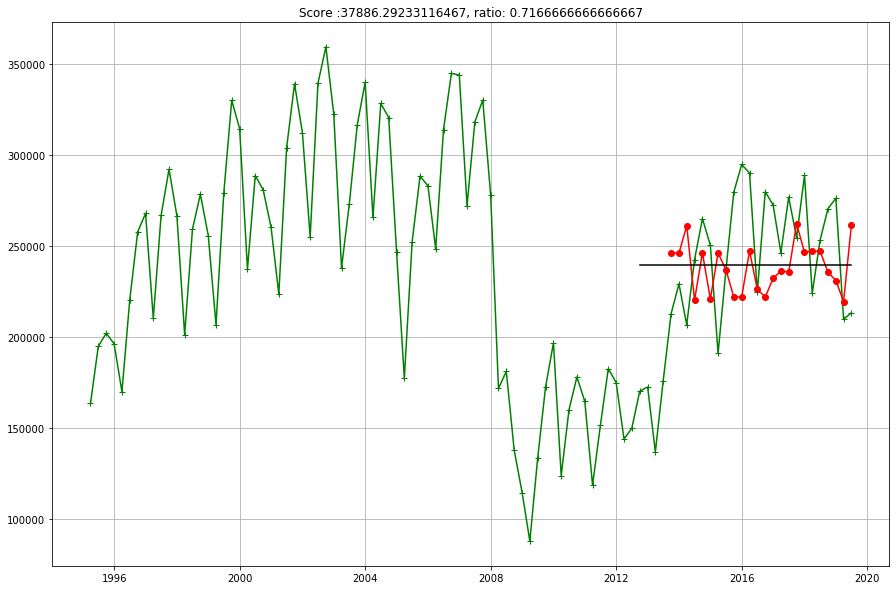

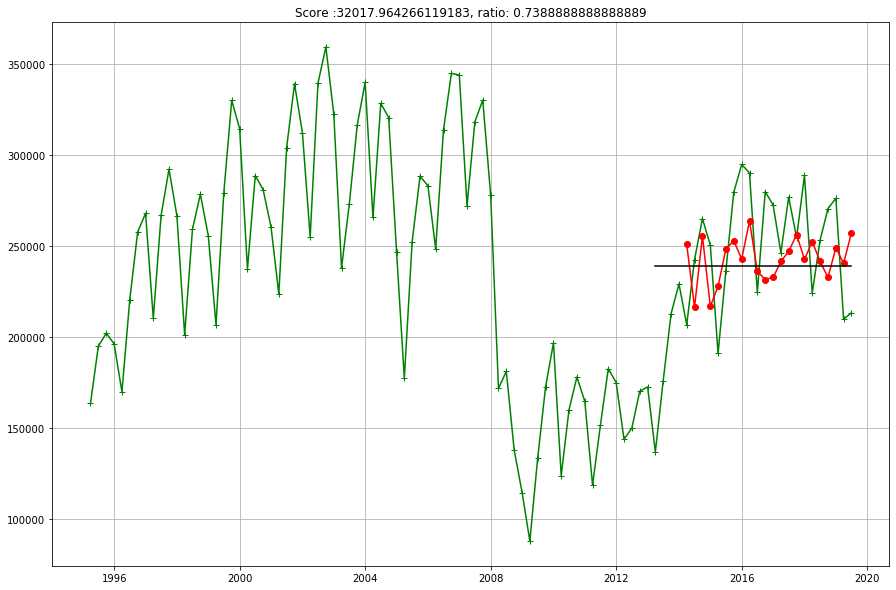

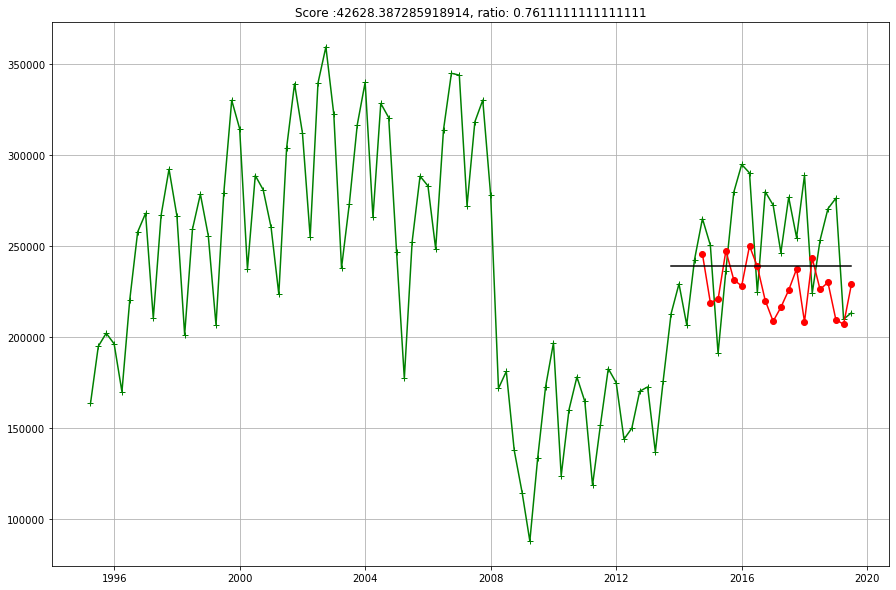

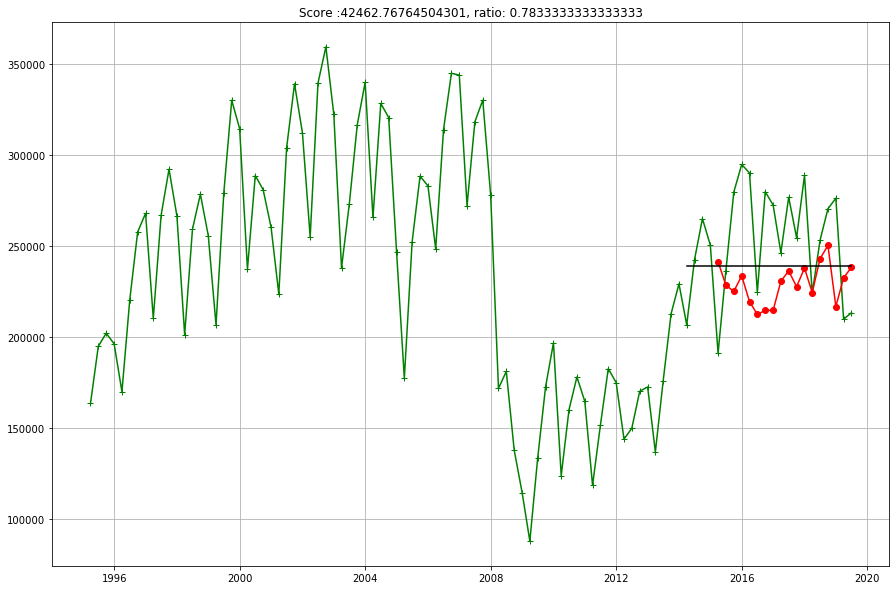

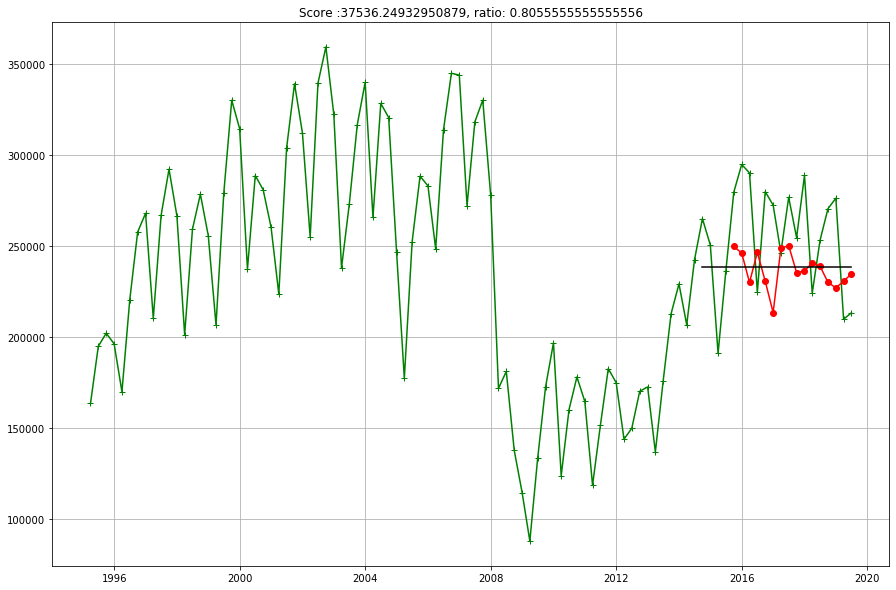

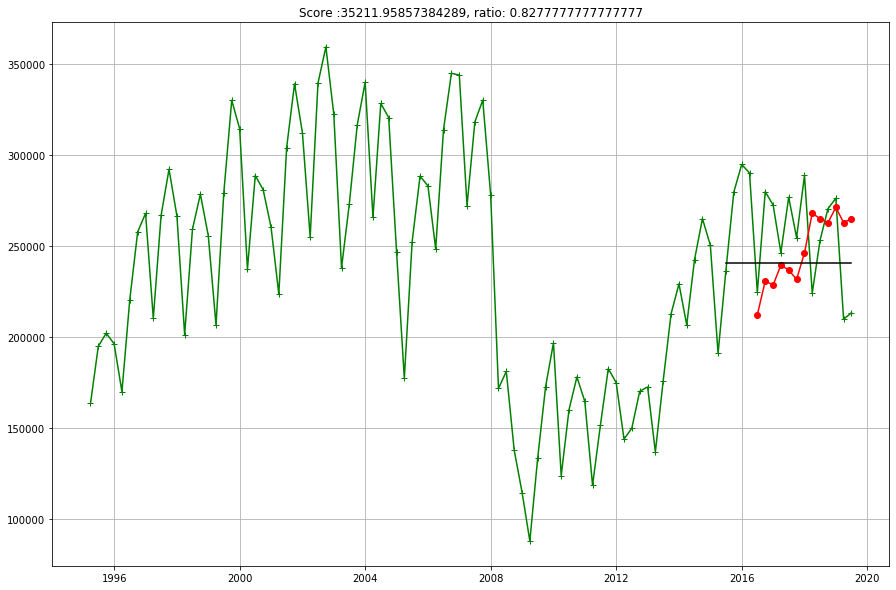

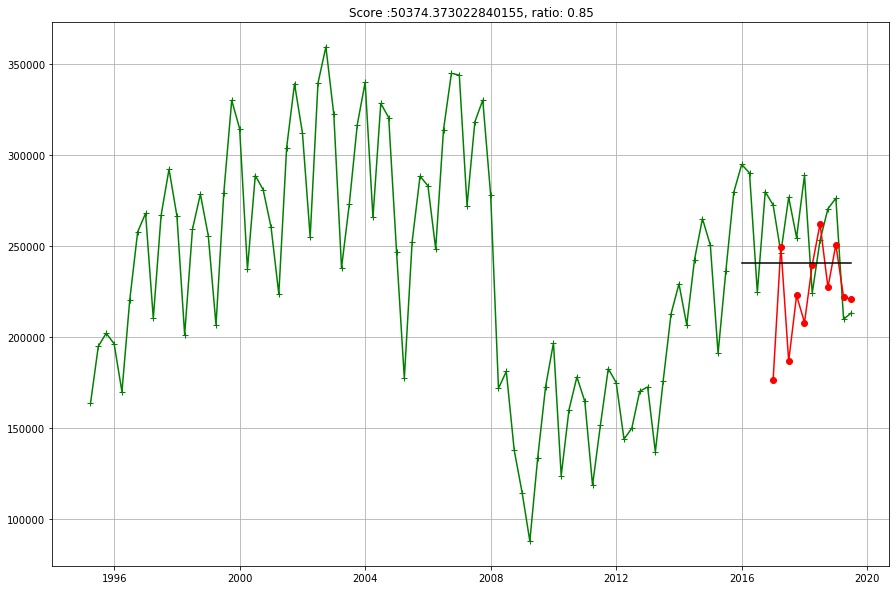

In [10]:
# Check stability across different training ratios
chosen_params = best_models[0].lgbm_kwargs

iterate_split_ratio(df_load, "sales", "event_date", 4, 'Q', chosen_params, 
                        x0=0.65, x1=0.85, n=10, verbose=True)

### ELI5 Permutation Importance

In [11]:
# Call model paramaters
# print(best_models[0].X_train.columns.tolist()[12])
# print(best_models[0].model.booster_.feature_name())

In [12]:
# Inbuilt LGBM feature_importance (based on number of splits)
lgb_fi_df = (pd.DataFrame(best_models[0].model.feature_importances_, 
                 best_models[0].X_train.columns.tolist())
            .rename(columns={0: "lgb_feature_importance"})
            .sort_values(by='lgb_feature_importance', ascending=False))

In [13]:
# Set permutation importance class
pi = eli5.sklearn.permutation_importance.PermutationImportance(best_models[0].model)

# Recreate input X_train features
X_train_scaled = best_models[0].prepare_data(best_models[0].X_train)
X_train_scaled = X_train_scaled.fillna(X_train_scaled.mean())

# Fit the X_train and y_train to the eli5 permutation importance function
fi = pi.fit(X_train_scaled, best_models[0].y_train).feature_importances_

fi_df = (pd.DataFrame(fi, X_train_scaled.columns.tolist())
            .rename(columns={0: "eli5_feature_importance"})
            .sort_values(by='eli5_feature_importance', ascending=False)
            )

In [14]:
lgb_fi_df.join(fi_df)

,lgb_feature_importance,eli5_feature_importance
ftse_mom_pct,17,0.068948
house_price_qoq_pct,16,0.074343
new_build_premium_qoq_pct,15,0.070598
FTSE_Price,12,0.026218
unemployment_qoq_pct,12,0.039129
libor_qoq_pct,8,0.018280
stamp_duty_bn_adj,7,0.018650
libor_rate_pct,7,0.017381
house_price,2,0.000850
ftse_qoq_pct,2,0.002968


In [15]:
# Eli5 feature importance
eli5.explain_weights(best_models[0].model, importance_type='gain')

Weight,Feature
0.2298,house_price_qoq_pct
0.2257,new_build_premium_qoq_pct
0.1609,ftse_mom_pct
0.1166,unemployment_qoq_pct
0.0923,FTSE_Price
0.0530,stamp_duty_bn_adj
0.0478,libor_rate_pct
0.0467,libor_qoq_pct
0.0092,ftse_qoq_pct
0.0090,unemployment_pct


### MODEL 1 - Shap investigation

In [221]:
# Convert training set to format for shaps
X_df = best_models[0].X_train

In [222]:
# Set up explainer and shap_values
Xplainer = shap.TreeExplainer(best_models[0].model)
shap_vals = Xplainer.shap_values(X_df.values)

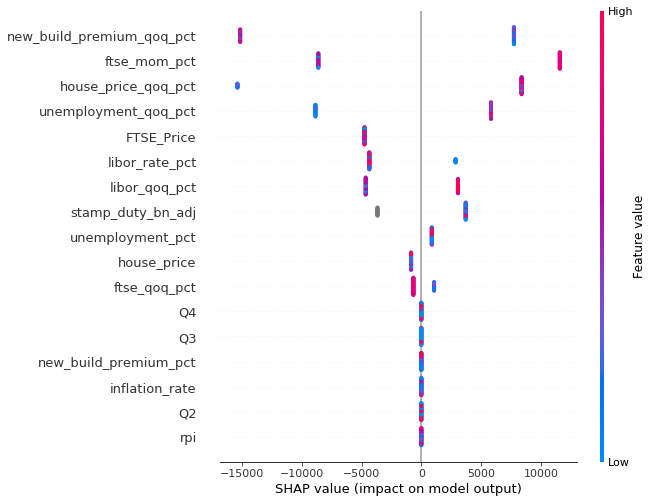

In [223]:
shap.summary_plot(features=X_df, shap_values=shap_vals)

In [224]:
X_df.head()

,rpi,libor_rate_pct,libor_qoq_pct,FTSE_Price,ftse_mom_pct,ftse_qoq_pct,unemployment_pct,unemployment_qoq_pct,house_price,new_build_premium_pct,house_price_qoq_pct,new_build_premium_qoq_pct,inflation_rate,stamp_duty_bn_adj,Q2,Q3,Q4
event_date,,,,,,,,,,,,,,,,,
2006-09-30,789.4,5.327619,1.390674,5896.100,0.312582,4.023430,5.5,0.000000,168459.893923,4.111278,2.075292,-11.337510,1.0233,1.127039,0,1,0
1999-03-31,647.4,4.944783,-10.133765,6613.000,-0.646034,-1.927925,6.2,0.000000,67477.563486,18.039015,1.756383,-4.236522,1.0133,NaN,0,0,0
1996-03-31,597.7,5.382857,-8.101100,4373.000,1.982276,6.192326,8.3,-1.190476,51367.000000,21.287986,0.858040,-8.444760,1.0243,NaN,0,0,0
1997-06-30,621.3,6.042273,9.402005,5510.000,1.156600,3.513057,7.3,1.388889,58403.000000,23.096416,4.646121,-12.544203,1.0183,NaN,1,0,0
2002-03-31,688.4,1.893500,-2.847614,5252.405,2.449969,1.372854,5.2,0.000000,95356.000000,11.933609,3.050803,-7.428023,1.0126,0.510966,0,0,0


In [225]:
# Note the converstion of datetime index to row number with len function
event = '2009-09-30'
i = len(X_df.loc[X_df.index <= event])
display(shap.force_plot(features=X_df.loc[event], shap_values=shap_vals[i], base_value=Xplainer.expected_value))

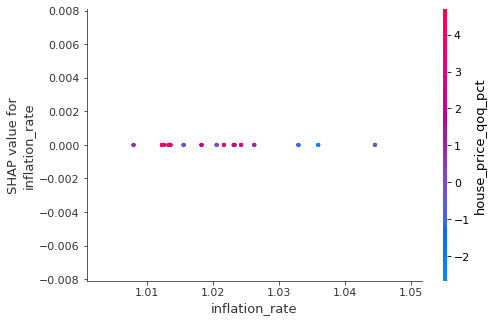

In [226]:
# Shap dependence plot
shap.dependence_plot(features=X_df, shap_values=shap_vals, 
                          ind="inflation_rate", 
                          interaction_index="house_price_qoq_pct")